# Data Cleaning
Import the data and clean for EDA. Drop columns that don't relate to our analysis, drop rows with unusable data or that are not in our time frame (2015-2019).

In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [8]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
pd.set_option('display.max_columns', 25)

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.api import OLS

import seaborn as sns
sns.set()

In [9]:
### cs109default ### 
import random
random.seed(112358)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.model_selection import GridSearchCV
from random import randint 

from sklearn import tree
%matplotlib inline

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

from sklearn.utils import shuffle

__Read in Files__ from csv into pandas dataframes.

In [10]:
property_2019_full    = pd.read_csv('data/property-assessment-fy2019.csv')
property_2018_full    = pd.read_csv('data/property-assessment-fy2018.csv')
property_2017_full    = pd.read_csv('data/property-assessment-fy2017.csv')
property_2016_full    = pd.read_csv('data/property-assessment-fy2016.csv')
property_2015_full    = pd.read_csv('data/property-assessment-fy2015.csv')
streetlights_full     = pd.read_csv('data/streetlight_locations.csv')
crime_incidents_full  = pd.read_csv('data/crime_incident_reports.csv')

__Read in 311__ seperately because it takes longer so you don't have to run if not needed.

In [11]:
#incident_reports_full = pd.read_csv('data/311.csv')

__Drop Columns__ after careful inspection of the data contained in each dataset, drop columns that will not help in our modeling. Columns were dropped if they had no effect on the outcome of interest (such as indeces or number of fireplaces in a property) or if the information in them was a duplicate (such as location if we were already given longitude and latitude).

1. from `streetlamps` drop everything but `Long` and `Lat`
2. from `property_assessment` we only care where the property is and what it's valued at so drop everything that doesn't relate
3. from `crime_incidents` drop `Location` and the index, since the location information was duplicationg `Long` and `Lat` and the index was not useful for analysis

In [12]:
# drop everything but lat and long
streetlights = streetlights_full.drop(['the_geom','TYPE','OBJECTID'],axis=1)

In [13]:
# list of columns to save for properties
property_cols = ['ST_NUM','ST_NAME','ST_NAME_SUF','UNIT_NUM','ZIPCODE',
                 'AV_LAND','AV_BLDG','AV_TOTAL','GROSS_TAX']

# drop all columns not in list (keep _ at end of name to show not fully clean yet)
property_2019_ = property_2019_full[property_2019_full.columns[property_2019_full.columns.isin(property_cols)]]
property_2018_ = property_2018_full[property_2018_full.columns[property_2018_full.columns.isin(property_cols)]]
property_2017_ = property_2017_full[property_2017_full.columns[property_2017_full.columns.isin(property_cols)]]
property_2016_ = property_2016_full[property_2016_full.columns[property_2016_full.columns.isin(property_cols)]]
property_2015_ = property_2015_full[property_2015_full.columns[property_2015_full.columns.isin(property_cols)]]

In [14]:
# list of columns to drop for crime incidents
#Offense Code is a numerical code of offense description (redundant data)
crime_cols_drop = ['INCIDENT_NUMBER','UCR_PART','Location', 'OFFENSE_CODE', 'OCCURRED_ON_DATE']

# drop columns and keep only descriptors of crime, date, and location
crime_incidents_ = crime_incidents_full.drop(crime_cols_drop,axis=1)


In [15]:
# Convert 'Shooting Column' into Integer Boolean

crime_incidents_['SHOOTING'].fillna(0, inplace = True)
crime_incidents_['SHOOTING'].astype(str).value_counts()
#print(crime_incidents_['SHOOTING'].value_counts())

crime_incidents_['SHOOTING'].replace(('Y'), ('1'), inplace=True)
crime_incidents_['SHOOTING'] = crime_incidents_['SHOOTING'].astype(int)
crime_incidents_['SHOOTING'].value_counts()



0    437453
1      1849
Name: SHOOTING, dtype: int64

__Drop Rows__ that would not be usable in the forseeable future. This includes rows that have no predictor data, or no response variable data, in the form of 'nan' or 'none' or in some cases zeros. Careful inspection of each dataset led us to drop the following:
1. the `streetlights` dataset had no rows with immediately visible issues
2. from `property_assessment` we dropped all rows that had 0 in all four of the price variables, no issues with location were immediately visible
3. from `crime_incidents` we dropped if `Lat` and `Long` did not have usable values because it would be hard to get that information just from the street name and it is vital to our analysis

In [16]:
# drop row if all price values are 0
def property_droprows(df):
    df_new = df[(df.AV_LAND != 0)  | (df.AV_BLDG != 0) | (df.AV_TOTAL != 0) | (df.GROSS_TAX != 0)]
    return(df_new)

In [17]:
# drop property rows for all years
property_2019 = property_droprows(property_2019_)
property_2018 = property_droprows(property_2018_)
property_2017 = property_droprows(property_2017_)
property_2016 = property_droprows(property_2016_)
property_2015 = property_droprows(property_2015_)

# Linking Data

### Deal with NA values in the crime_incidents report

In [18]:
#Deal with NA Values for LAT/LONG in crime reports
import pandas as pd

# drop rows with nan long and lat 
crime_incidents = crime_incidents_.dropna(subset=['Lat','Long'])

crime_incidents_nonull = crime_incidents_.dropna(how='any',axis=0) 
crime_incidents_[crime_incidents_['SHOOTING'].isna()]['SHOOTING'] = 0



### Associating Data

Describe how you will associate the location data in Street Lights with the location data in the Crime Incident Reports Dataset

In [19]:
#streetlights
#crime_incidents_nonull

In [20]:
# Define Lat and Long List to six floating point characters
from collections import Counter

lat = streetlights['Lat'].values
lat = [ '%.6f' % elem for elem in lat ]
long = streetlights['Long'].values
long = [ '%.6f' % elem for elem in long ]

crime_incidents_nonull_streetlamps = crime_incidents.round(6)


In [21]:
# JOIN WITH STREET LAMP DATA

crime_incidents_nonull_streetlamps['LatSame'] = crime_incidents_nonull_streetlamps['Lat'].isin(lat) 
crime_incidents_nonull_streetlamps['LongSame'] = crime_incidents_nonull_streetlamps['Long'].isin(long)
crime_incidents_nonull_streetlamps_idx = crime_incidents_nonull_streetlamps.index[(crime_incidents_nonull_streetlamps['LatSame'] == True) & (crime_incidents_nonull_streetlamps['LongSame'] == True)].tolist()

crime_incidents_['in_streetlight'] = crime_incidents_.index.isin(crime_incidents_nonull_streetlamps_idx)
crime_incidents_['in_streetlight'].value_counts()


False    342164
True      97138
Name: in_streetlight, dtype: int64

__Cluster Effects__

Check Factor variables, random effect when clustered observation

WASHINGTON ST        17.330255
BLUE HILL AVE         9.408096
BOYLSTON ST           8.224629
DORCHESTER AVE        5.857694
TREMONT ST            5.804868
HARRISON AVE          5.751191
MASSACHUSETTS AVE     5.522847
CENTRE ST             5.261274
COMMONWEALTH AVE      4.799475
HYDE PARK AVE         4.289962
COLUMBIA RD           3.764261
HUNTINGTON AVE        3.463495
RIVER ST              3.410669
DUDLEY ST             2.879855
COLUMBUS AVE          2.710302
WARREN ST             2.654068
ADAMS ST              2.367787
NEWBURY ST            2.241686
BEACON ST             2.239130
CAMBRIDGE ST          2.018455
Name: STREET, dtype: float64

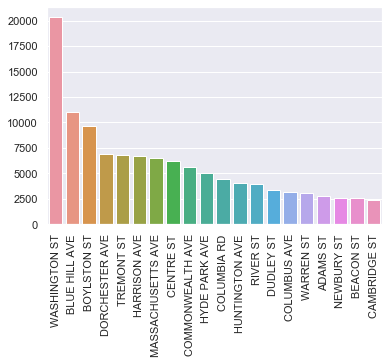

In [22]:
value_street = crime_incidents_['STREET'].value_counts()[:20]
sns.barplot(value_street.index, value_street.values)
plt.xticks(rotation=90)

value_street_percent = value_street * 100. /value_street.sum()
value_street_percent

SICK/INJURED/MEDICAL - PERSON            10.978371
INVESTIGATE PERSON                       10.515326
M/V - LEAVING SCENE - PROPERTY DAMAGE     9.143388
VANDALISM                                 8.271751
ASSAULT SIMPLE - BATTERY                  8.142377
VERBAL DISPUTE                            7.689158
INVESTIGATE PROPERTY                      6.401150
TOWED MOTOR VEHICLE                       6.281192
THREATS TO DO BODILY HARM                 5.133611
LARCENY THEFT FROM BUILDING               5.013244
PROPERTY - LOST                           5.008741
LARCENY THEFT FROM MV - NON-ACCESSORY     4.772510
WARRANT ARREST                            4.519085
LARCENY SHOPLIFTING                       4.485104
M/V ACCIDENT - PROPERTY  DAMAGE           3.644991
Name: OFFENSE_DESCRIPTION, dtype: float64

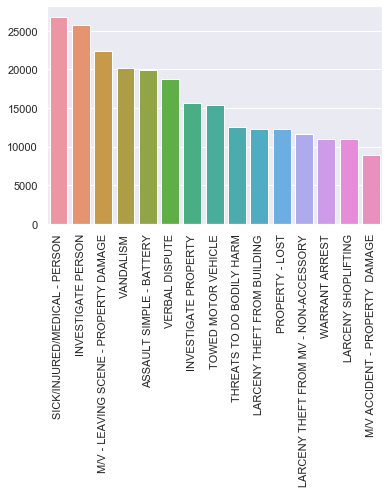

In [23]:
value_offense_description = crime_incidents_['OFFENSE_DESCRIPTION'].value_counts()[:15]
sns.barplot(value_offense_description.index, value_offense_description.values)
plt.xticks(rotation=90)

value_offense_description_percent = value_offense_description * 100. / value_offense_description.sum()
value_offense_description_percent[:15]

In [24]:
offense_code_description = crime_incidents_['OFFENSE_CODE_GROUP'].value_counts()
offense_code_description_percent = offense_code_description * 100. / offense_code_description.sum()
offense_code_description_percent[:15]

Motor Vehicle Accident Response    11.620982
Larceny                             8.141224
Medical Assistance                  7.670556
Investigate Person                  5.799597
Other                               5.634430
Drug Violation                      5.167042
Simple Assault                      5.001874
Vandalism                           4.716521
Verbal Disputes                     4.158467
Investigate Property                3.550042
Towed                               3.499906
Larceny From Motor Vehicle          3.254615
Property Lost                       3.145675
Warrant Arrests                     2.585981
Aggravated Assault                  2.503983
Name: OFFENSE_CODE_GROUP, dtype: float64

In [25]:
X_train

NameError: name 'X_train' is not defined

# Data Analysis: Train Model using Street Lights and Crime

Are certain crimes more likely to occur where there is a dearth of street lights? Is there correlation with well-lit streets and the location of the crime?


In [26]:
crime_incidents_dummies = pd.get_dummies(crime_incidents, columns=["OFFENSE_CODE_GROUP", 'OFFENSE_DESCRIPTION', 'DISTRICT', 'DAY_OF_WEEK', 'STREET'])



In [21]:
crime_incidents_train, crime_incidents_test = train_test_split(crime_incidents_dummies, test_size=0.2, random_state = 109)

In [22]:
X_train = crime_incidents_train.loc[:, crime_incidents_train.columns != 'SHOOTING']
y_train = crime_incidents_train.SHOOTING

In [23]:
# Divide into In_Street and Not_in_Street
in_street = crime_incidents_[crime_incidents_['in_streetlight'] == True]

not_in_street = crime_incidents_[crime_incidents_['in_streetlight'] == False]


Larceny                                      9.816961
Motor Vehicle Accident Response              9.312524
Medical Assistance                           7.369927
Drug Violation                               5.921473
Investigate Person                           5.646606
                                               ...   
Phone Call Complaints                        0.009265
Explosives                                   0.006177
Biological Threat                            0.002059
INVESTIGATE PERSON                           0.002059
HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE    0.001029
Name: OFFENSE_CODE_GROUP, Length: 63, dtype: float64

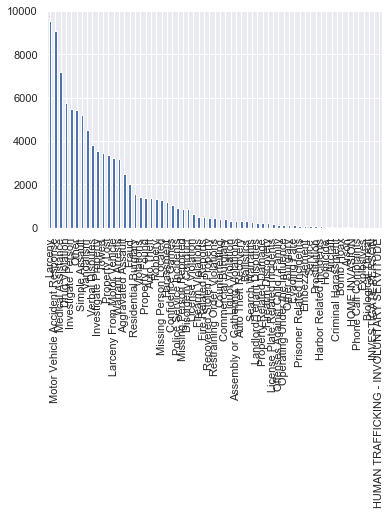

In [24]:
in_street['OFFENSE_CODE_GROUP'].value_counts().plot.bar()
in_street['OFFENSE_CODE_GROUP'].value_counts() * 100 / in_street['OFFENSE_CODE_GROUP'].value_counts().sum()

Motor Vehicle Accident Response              12.301108
Medical Assistance                            7.759128
Larceny                                       7.647512
Investigate Person                            5.844672
Other                                         5.652377
                                               ...    
Gambling                                      0.002426
Burglary - No Property Taken                  0.001517
INVESTIGATE PERSON                            0.000910
HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE     0.000910
Biological Threat                             0.000303
Name: OFFENSE_CODE_GROUP, Length: 67, dtype: float64

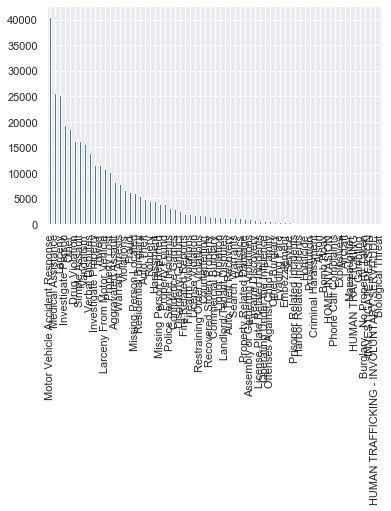

In [25]:
not_in_street['OFFENSE_CODE_GROUP'].value_counts().plot.bar()
not_in_street['OFFENSE_CODE_GROUP'].value_counts() * 100 / not_in_street['OFFENSE_CODE_GROUP'].value_counts().sum()

In [26]:
print(not_in_street['SHOOTING'].value_counts()) #(0.432061803 of crimes are shooting)
in_street['SHOOTING'].value_counts() #(0.389619784830 of crimes are shooting)

0    340692
1      1472
Name: SHOOTING, dtype: int64


0    96761
1      377
Name: SHOOTING, dtype: int64

## Fit Tree
Fit two tree based models: one with max_depth = 20 (call it tree20) and one with a best_depth that is chosen via 5-fold cross-validation (call it tree_best) using all predictors. 

In [27]:
### cs109Test (test_4.4) ### 

NN_model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(15, input_shape=(X_train.shape[1], ), activation='relu'),
      tf.keras.layers.Dense(15, input_shape=(X_train.shape[1], ), activation='relu'),
  tf.keras.layers.Dense(1, activation='linear'),
])

NameError: name 'tf' is not defined

In [29]:
#Build Model 3 to Predict Shooting

kf = KFold(n_splits = 5, random_state = 90)

ks = [1,2,3,4,5,7,9,10,15,25]
cross_vals = []

for k in ks:
    knn = KNeighborsClassifier(k).fit(X_train, y_train)
    cross_vals.append(np.mean(cross_val_score(knn, X_train, y_train, cv=kf)))
    
best_k = ks[np.argmax(cross_vals)]

knn = KNeighborsClassifier(best_k).fit(X_train, y_train)
y_train_pred_knn = knn.predict(X_train)
y_test_pred_knn = knn.predict(X_test)

train_acc_knn = accuracy_score(y_train, y_train_pred_knn)
test_acc_knn = accuracy_score(y_test, y_test_pred_knn)
print("kNN Accuracy Scores\nTraining Accuracy: " + str(train_acc_knn) + "\nTest Accuracy: " + str(test_acc_knn))



ValueError: could not convert string to float: 

# Data Analysis: Train Model using Property Values and Crime

first approximation and proxy of economic disparity

In [ ]:
#Find optimal depth of trees
cvmeans = {}
cvmeanstest = {}
train_scores = {}
test_scores = {}
tree_depth_start, tree_depth_end = 1, 20
for i in range(tree_depth_start, tree_depth_end):
    model = DecisionTreeClassifier(max_depth=i, random_state=109)
    score = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5, n_jobs=-1)
    train_scores[i] = score
    cvmeans[i] = score.mean()
    
    
x = list(cvmeans.keys())
y = list(cvmeans.values())
lists = sorted(cvmeans.items())
x, y = zip(*lists)  
cvstds = np.array([ np.std(score) for score in train_scores.values() ])

best_depth = sorted(cvmeans, key=cvmeans.get, reverse=True)[0]
print("The best depth was found to be:", best_depth)

tree_best = DecisionTreeClassifier(max_depth=best_depth, random_state=109)
tree_best.fit(X_train, y_train)



In [ ]:
fig, ax = plt.subplots()
feat_import_treebest = pd.Series(tree_best.feature_importances_, index = X_train_og.columns) 
feat_import_treebest.nlargest(10).plot(kind = 'barh', title = "Variable Importance Tree_Best")
